# Steel Plate Detection Prediction

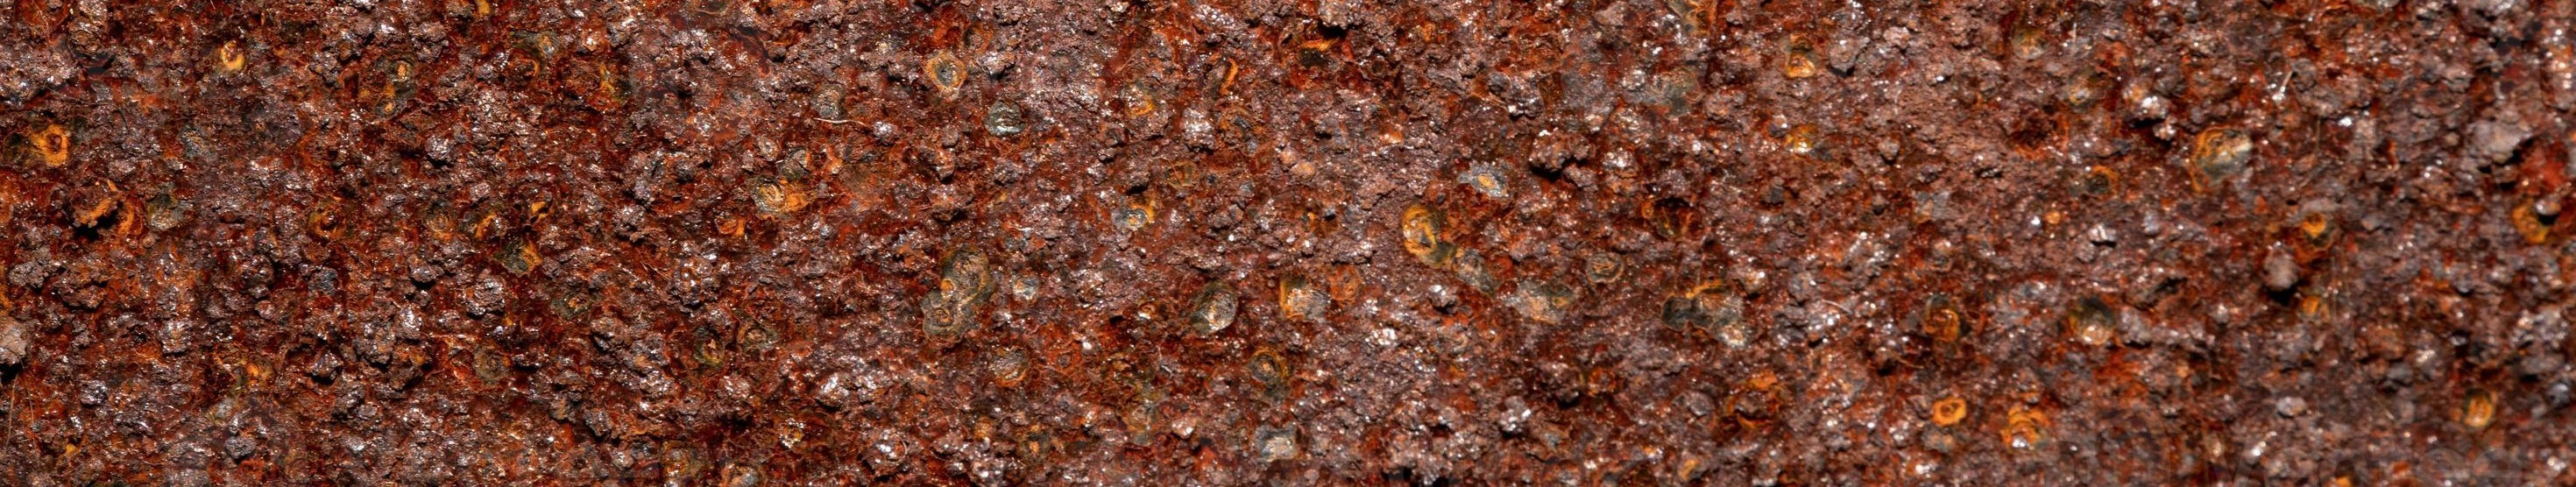

1. __Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

2. __Files__
`train.csv` - the training dataset; there are 7 binary targets: `Pastry`, `Z_Scratch`, `K_Scatch`, `Stains`, `Dirtiness`, `Bumps`, `Other_Faults`
`test.csv` - the test dataset; your objective is to predict the probability of each of the 7 binary targets
`sample_submission.csv` - a sample submission file in the correct format

3. __Evaluation__
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.
To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.

4. __Submission File__
For each id in the test set, you must predict the probability for each of 7 defect categories: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The file should contain a header and have the following format:

    ```python
    id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
    19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    etc.
    ```

5. __Citation__
    * <a href="https://kaggle.com/competitions/playground-series-s4e3">Walter Reade, Ashley Chow, Steel Plate Defect Prediction, Kaggle, 2024</a>

## Import Dependencies

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from math import ceil
from scipy.stats import randint, uniform
import json

## Helper Functions

In [2]:
# Save model parameters
def save_params(params, filename):
    with open(filename, 'w') as file:
        json.dump(params, file)
    print(f"Best parameters saved to: '{filename}'.")
 
 
    
# Load model parameters
def load_params(filename):
    try:
        with open(filename, 'r') as file:
            params = json.load(file)
    except json.JSONDecodeError:
        raise ValueError(f"Error: '{filename}' is not a valid JSON file or is empty.")
    else:
        print(f"Parameters loaded from: '{filename}'.")
        
    return params



# Remove all-zero rows
def remove_all_zero_columns(df:pd.DataFrame):
    all_zero_rows = df.sum(axis=1)==0
    print(f'Removing {len(all_zero_rows)} rows ...')
    return df[~all_zero_rows].reset_index(drop=True)



def compute_lower_upper_bounds(df:pd.DataFrame, col:str, method:str='IQR', **kwargs) -> tuple:
    """

    Args:
        df (pd.DataFrame): dataframe to compute the lower and upper bounds
        col (str): column in 'df' to compute the bounds
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'IQR'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        tuple: (lower_bound, upper_bound) - lower and upper bounds for the column 'col' in 'df'
    """
    
    try:
        if method == 'IQR':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        elif method == 'ZScore':
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
        elif method == 'Percentile':
            limits = kwargs.get('limits', (0.01, 0.99))
            lower_bound = df[col].quantile(limits[0])
            upper_bound = df[col].quantile(limits[1])
    except Exception as e:
        print(f'Error: {e}')
        return None, None
    return lower_bound, upper_bound
    
    
    
def mask_outliers(df: pd.DataFrame, col:str, method:str='Percentile', **kwargs) -> pd.Series:
    """_summary_

    Args:
        df (pd.DataFrame): dataframe to mask the outliers
        col (str): column in 'df' to check for outliers
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        pd.Series: provide outlier mask for the column 'col' in 'df'
    """
    outlier_mask = pd.Series(False, index=df.index)
    lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method, limits=kwargs.get('limits', (0.01, 0.99)))
    outlier_mask = outlier_mask | ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outlier_mask



# Remove outliers rows
def remove_outliers(df:pd.DataFrame, y:pd.DataFrame=None, cols=[], **kwargs) -> tuple:
    """_summary_

    Args:
        df (pd.DataFrame): dataframe to remove outliers from
        y (pd.DataFrame, optional): target dataframe. Defaults to None.
        cols (list, optional): columns in 'df' to check for outliers. Defaults to [].
        **kwargs:
            method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.0005, 0.9995).

    Returns:
        tuple: (df_cleaned, y_cleaned) - cleaned dataframes
    """
    
    method = kwargs.get('method', 'Percentile')
    limits = kwargs.get('limits', (0.0005, 0.9995))
    cols = df.columns if cols==[] else cols
    
    outlier_mask = np.zeros(df.shape[0], dtype=bool)
    for col in cols:
        mask = mask_outliers(X, col, method=method, limits=(0.0005, 0.9995))
        outlier_mask |= mask # Combine masks for all columns
    return df[~outlier_mask], (y[~outlier_mask] if y is not None else None)



def count_outliers(df: pd.DataFrame, cols=[], method='Percentile', **kwargs) -> pd.Series:
    """

    Args:
        df (pd.DataFrame): dataframe to count the outliers
        cols (list, optional): columns in 'df' to count its outliers. Defaults to [].
        method (str, optional): method to use for outlier detection. Choose from 'Percentile', ZScore', 'IQR'. Defaults to 'Percentile'.
        **kwargs:
            limits (tuple, optional): limits for outlier detection, only used when method='Percentile'. Defaults to (0.01, 0.99).

    Returns:
        pd.Series: number of outliers for each column in 'cols'
    """
    if cols==[]: cols = df.columns
    outlier_counts = pd.Series(index=cols, dtype='float64')
    for col in cols:
        lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method=method, limits=kwargs.get('limits', (0.01, 0.99)))
        outlier_counts[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    return outlier_counts

#### Outliers

Outliers can affect model accuracy, especially for models that are sensitive to the range of the data, such as regression models. Here are some common methods to detect outliers in one-dimensional (univariate) data:

1. __Z-Score:__
Outliers are typically defined as points that have a Z-score greater than 3 or less than -3

2. __Interquartile Range (IQR):__
The IQR method defines outliers as points that fall below the first quartile (Q1) or above the third quartile (Q3) by a certain multiple of the IQR (commonly 1.5 times).

3. __Percentile-Based Method:__
This method flags values that fall beyond a specified percentile range, such as the 1st and 99th percentiles.
<br><br>


| Method               | Data Type              | Distribution Suitability       | Best For                   | Not Recommended When                  |
|----------------------|------------------------|--------------------------------|----------------------------|----------------------------------------|
| **Z-Score**          | Continuous             | Normal (Gaussian)              | Large datasets, quick detection | Skewed distributions, extreme outliers|
| **IQR**              | Continuous             | Any (especially non-normal)    | Skewed data, small datasets  | Uniform data, when mild outliers matter|
| **Percentile-Based** | Continuous             | Skewed or non-normal           | Large datasets, extreme outliers | Normally distributed data|



## Import Datasets

In [4]:
# Read csv files
data = pd.read_csv('./data/train.csv', header=0, index_col=0)
test = pd.read_csv('./data/test.csv', header=0, index_col=0)

# Create target and train dataframes
target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target = data[target_columns]
train = data.drop(target_columns, axis=1)

print(f'tarin: {train.shape}')
print(f'target: {target.shape}')
print(f'test: {test.shape}')

tarin: (19219, 27)
target: (19219, 7)
test: (12814, 27)


### 1. Target (Labels)

In [5]:
# Intances with at least one defect
positive_class = []
negative_class = []
for col in target_columns:
    percent = target[col].value_counts(normalize=True).round(3)*100
    negative_class.append(percent[0])
    positive_class.append(percent[1])
target_min1 = pd.DataFrame({'Class': target_columns, 'Negative': negative_class, 'Positive': positive_class}).sort_values(by='Positive', ascending=False)


# Intances with more than one defect
target_1plus = target[target.sum(axis=1)>1].value_counts().sum()


# Intances with no defect
target_0 = target[target.sum(axis=1)==0].value_counts().sum()


print(f'Instances with more than one defect: {target_1plus} ({target_1plus/len(target)*100:.2f}%)')
print(f'Instances with no defect: {target_0} ({target_0/len(target)*100:.2f}%)')

Instances with more than one defect: 21 (0.11%)
Instances with no defect: 818 (4.26%)


The rows with all-zero labels (i.e., no defect) represent a significant imbalance in the data, removing them could potentially improve performance, especially when models are struggling to learn patterns for the minority classes because the removed instances may contribute less valuable information to the model’s decision-making process. However, this could also introduce a bias if those all-zero instances have important relationships with features that the model should learn. Here, I do not remove these insances.

Additionally, there are instances that have more than one defect. This make the probelm a multi-label classification, because the labels are not mutually exclusive. Here, I will also keep these instances.

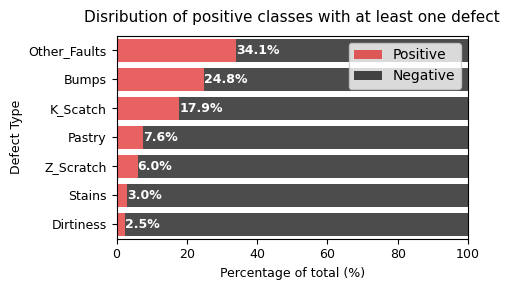

In [6]:
from tkinter import font


plt.figure(figsize=(5, 3))
ax = sns.barplot(x='Positive', y='Class', data=target_min1, width=.8, color='red', alpha=0.7, orient='h', label='Positive')
ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=9, color='white', weight='bold')
sns.barplot(x='Negative', y='Class', data=target_min1, width=.8, color='black', alpha=0.7, orient='h', left=target_min1['Positive'], label='Negative')
ax.set_xlim(0, 100)
plt.xlabel('Percentage of total (%)', fontsize=9)
plt.ylabel('Defect Type', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncols=2, fontsize=9)
plt.title('Disribution of positive classes with at least one defect', fontsize=11, pad=10)
plt.tight_layout()
plt.show()

### 2. Features

#### 2.1. Distribution

* `Train` and `Test` datasets have coparable distributions
* Not all features are notmally distributed
* There are outliers in dataset

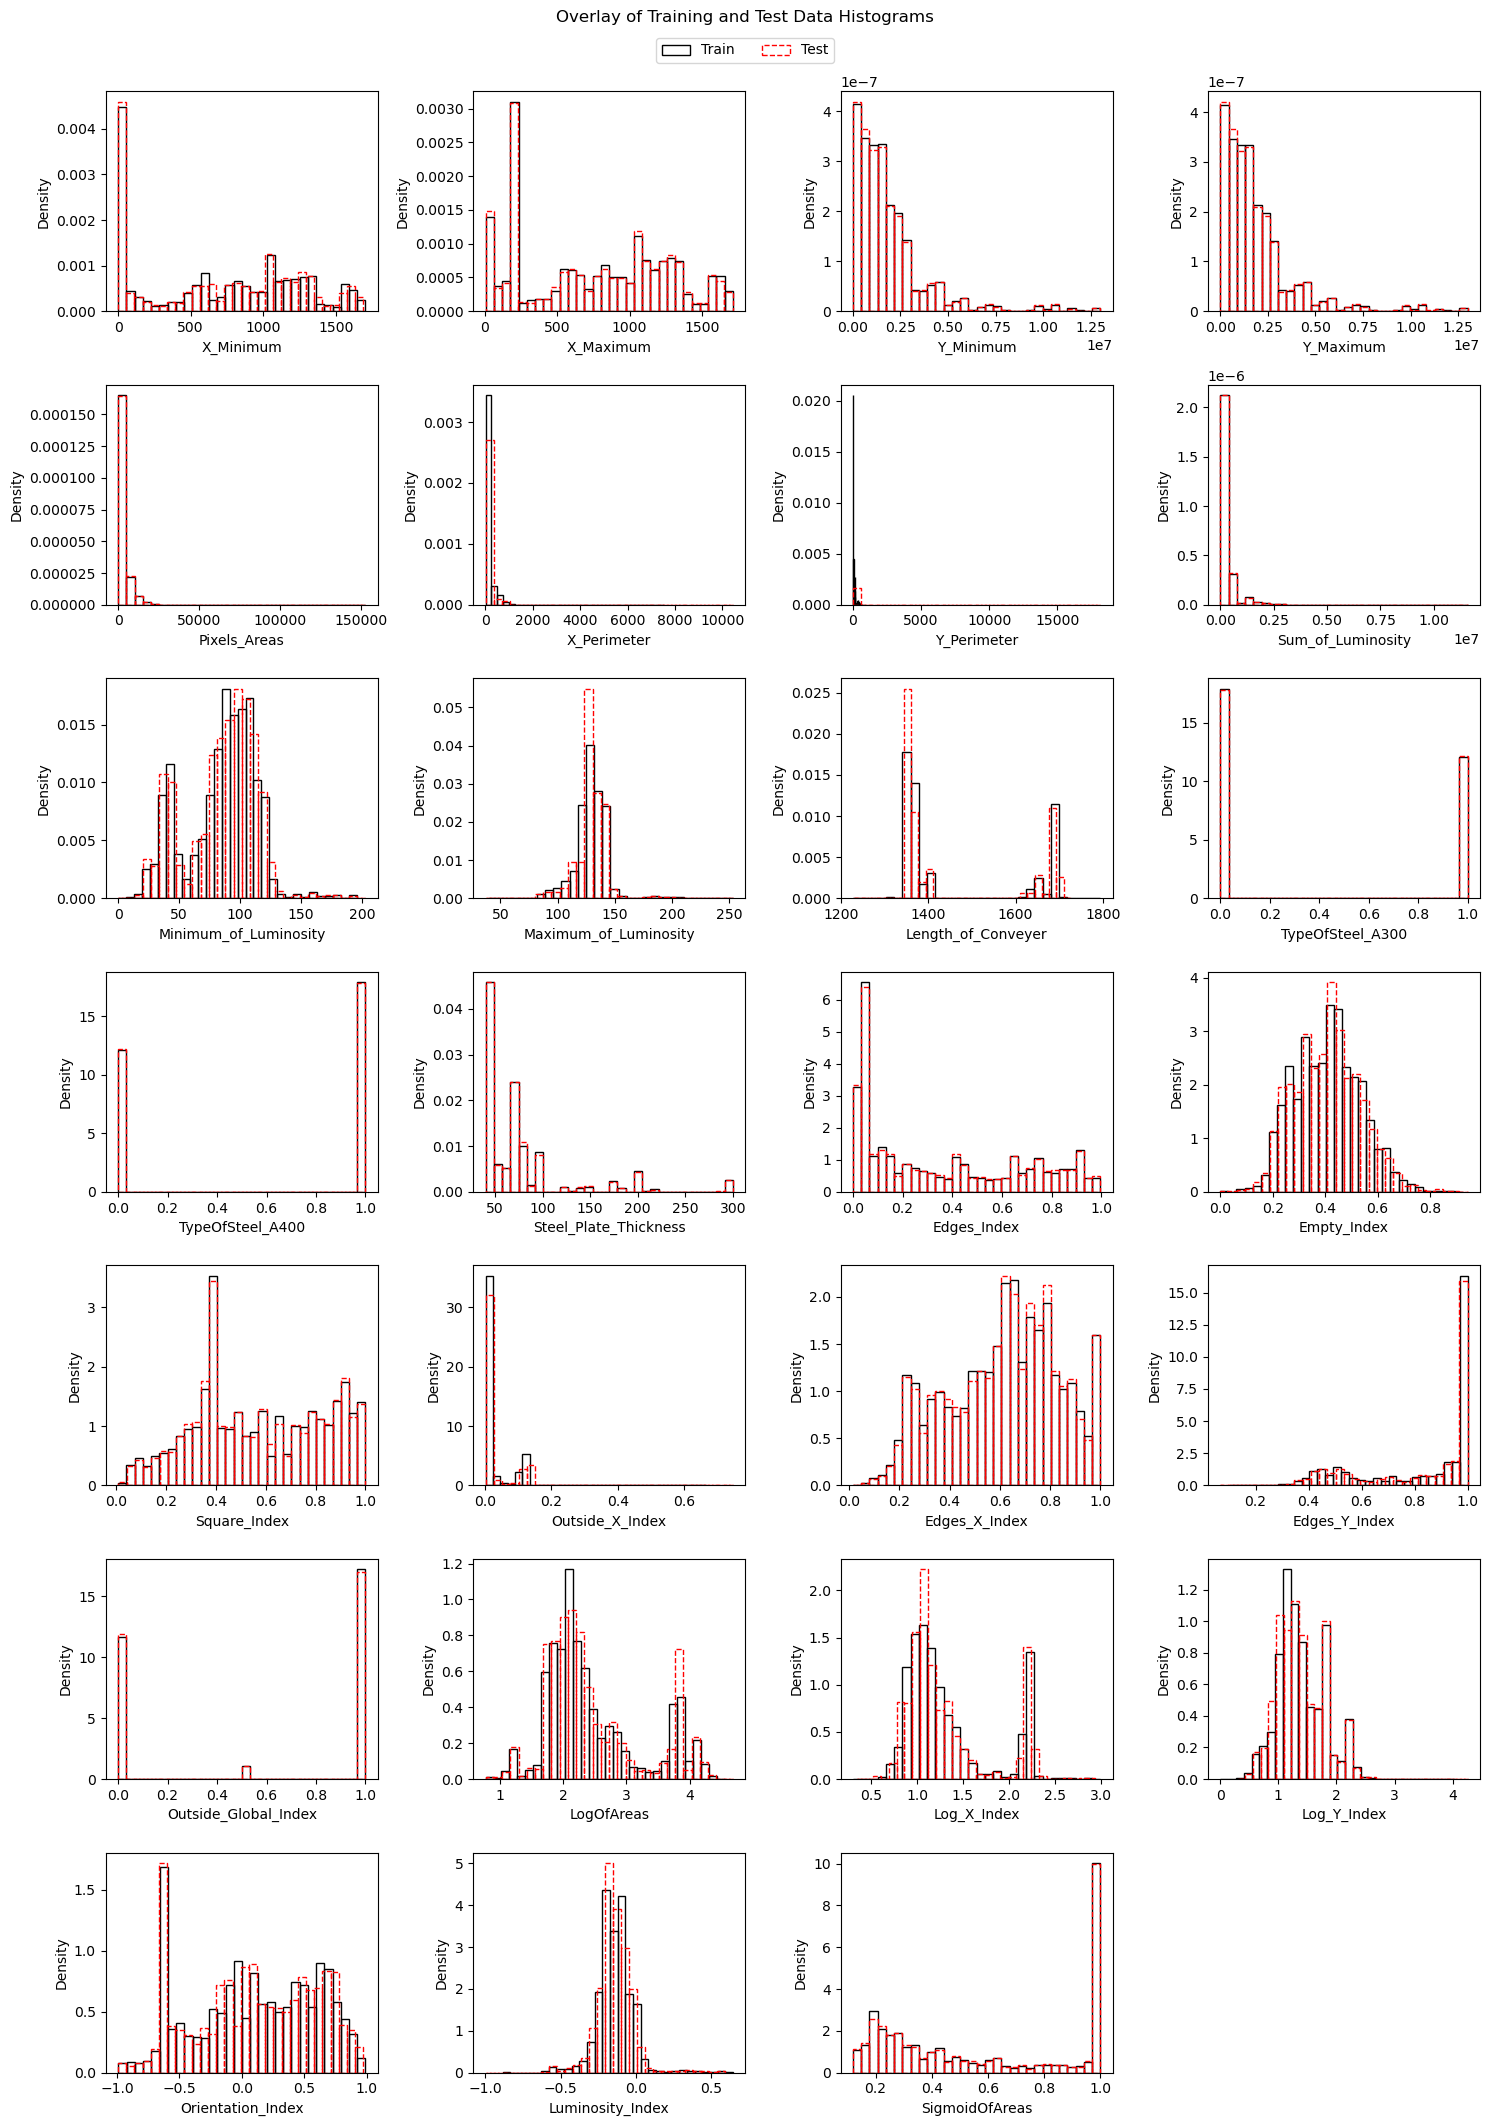

In [7]:
def overlay_hist(train_df, test_df, ncols):
    nrows = ceil(train_df.shape[1]/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten()
    features = train_df.columns
    for i in range(len(axes)):
        try:
            feature = features[i]
            sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Train', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            axes[i].set_xlabel(feature)
            axes[i].grid(False)
        except IndexError:
            fig.delaxes(axes[i])
    fig.suptitle('Overlay of Training and Test Data Histograms', y=1.01)
    handles, labels = axes[0].get_legend_handles_labels()    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize='medium')
    plt.tight_layout()
    plt.show()
    
    
overlay_hist(train, test, 4)

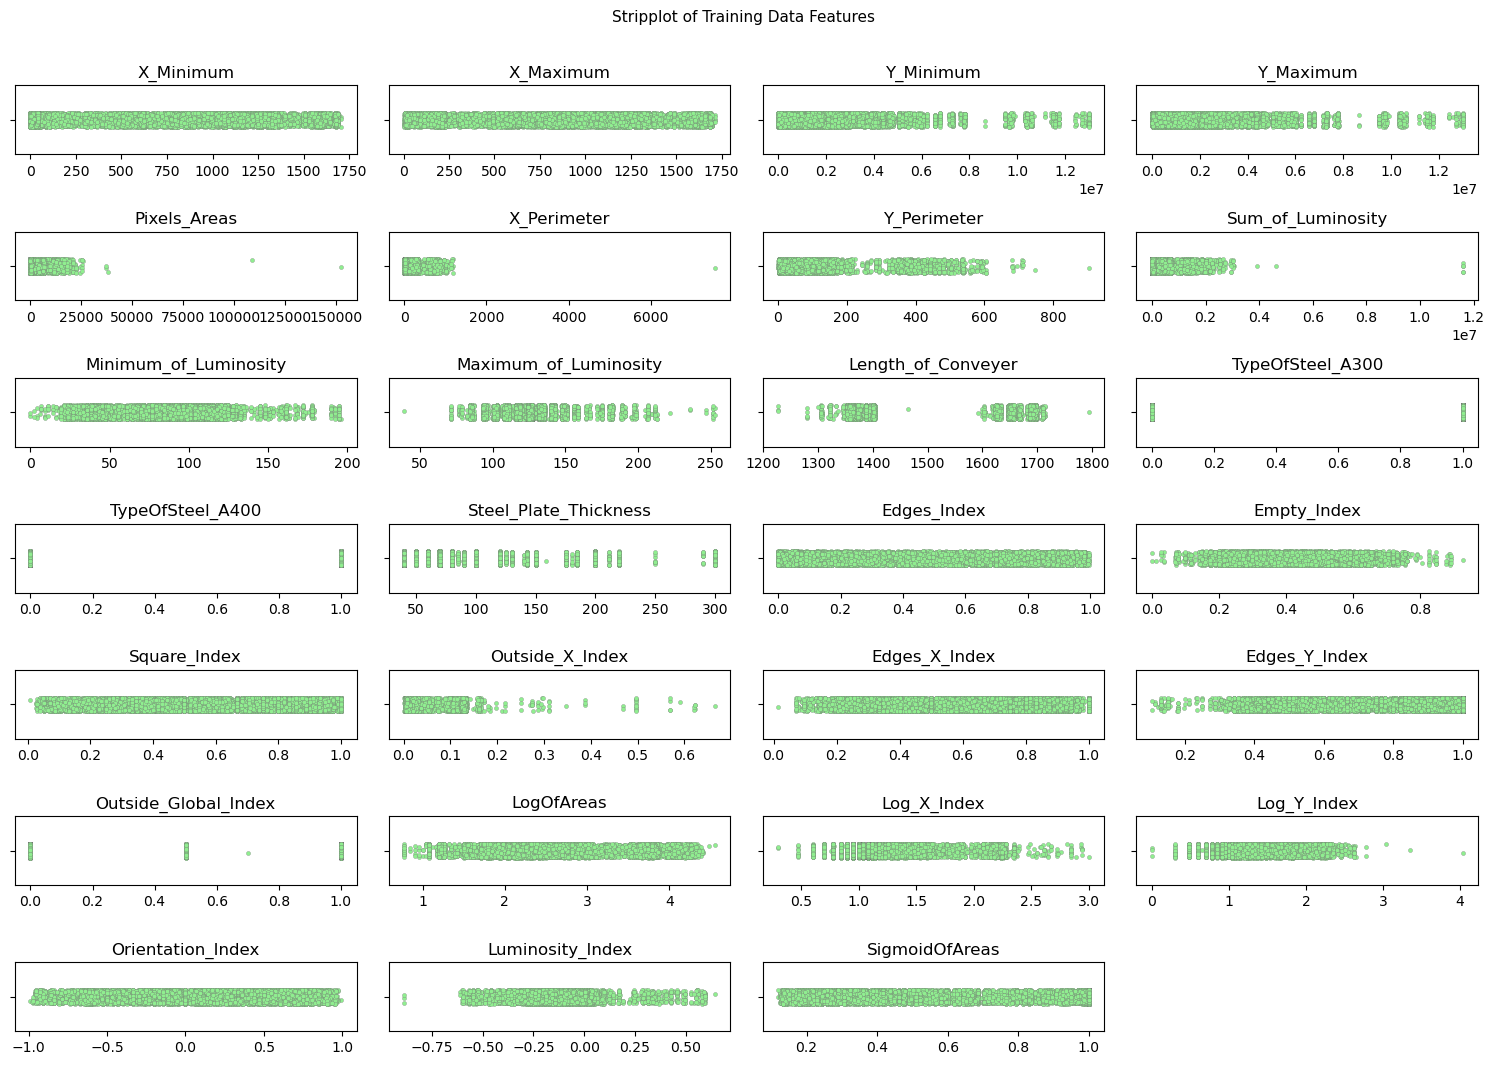

In [8]:
ncols = 4
nrows = ceil(train.shape[1]/ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 1.5 * nrows))
ax = ax.ravel()

for i, col in enumerate(train.columns):
    sns.stripplot(x=train[col], color='lightgreen', size=3, dodge=True, jitter=True, linewidth=0.2, ax=ax[i])

    ax[i].set_title(col)
    ax[i].set_xlabel('')
    
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])
    
fig.suptitle('Stripplot of Training Data Features', y=1.01, fontsize=11)    
plt.tight_layout()
plt.show()

### 2.2. Correlation

Three correlation methods, **Pearson**, **Kendall**, and **Spearman**, are common ways to measure relationships between variables, each with its own approach to quantifying correlation. 

| Method   | Measures            | Data Type        | Assumptions      | Strengths                  |
|----------|---------------------|------------------|------------------|----------------------------|
| Pearson  | Linear relationship | Continuous | Normally distributed | Best for linear relationships |
| Kendall | Ordinal association | Ordinal, non-parametric | None | Robust to outliers, good for small samples |
| Spearman | Monotonic relationship | Ordinal or non-normally distributed | None | Captures non-linear monotonic relationships |


__Spearman__ method assesses how well the relationship between two features of the dataset can be represented by a monotonic function.

It ranks each variable individually, then calculates Pearson’s correlation on the ranked data rather than the original data.

$$r_s = 1 - \frac{6 \sum{d_i^2}}{n(n^2-1)}$$

where $d_i$ is the difference in ranks for each observation, and $n$ is the number of observations. The Spearman's values range from -1 to 1. $r_s=1$ means perfect positive monotonic relationship while whereas $r_s=-1$ means perfect negative monotonic relationship. $r_s=0$ indicates no monotonic relationship.



In [9]:
cat_features = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
num_features = [feature for feature in train.columns if feature not in cat_features]

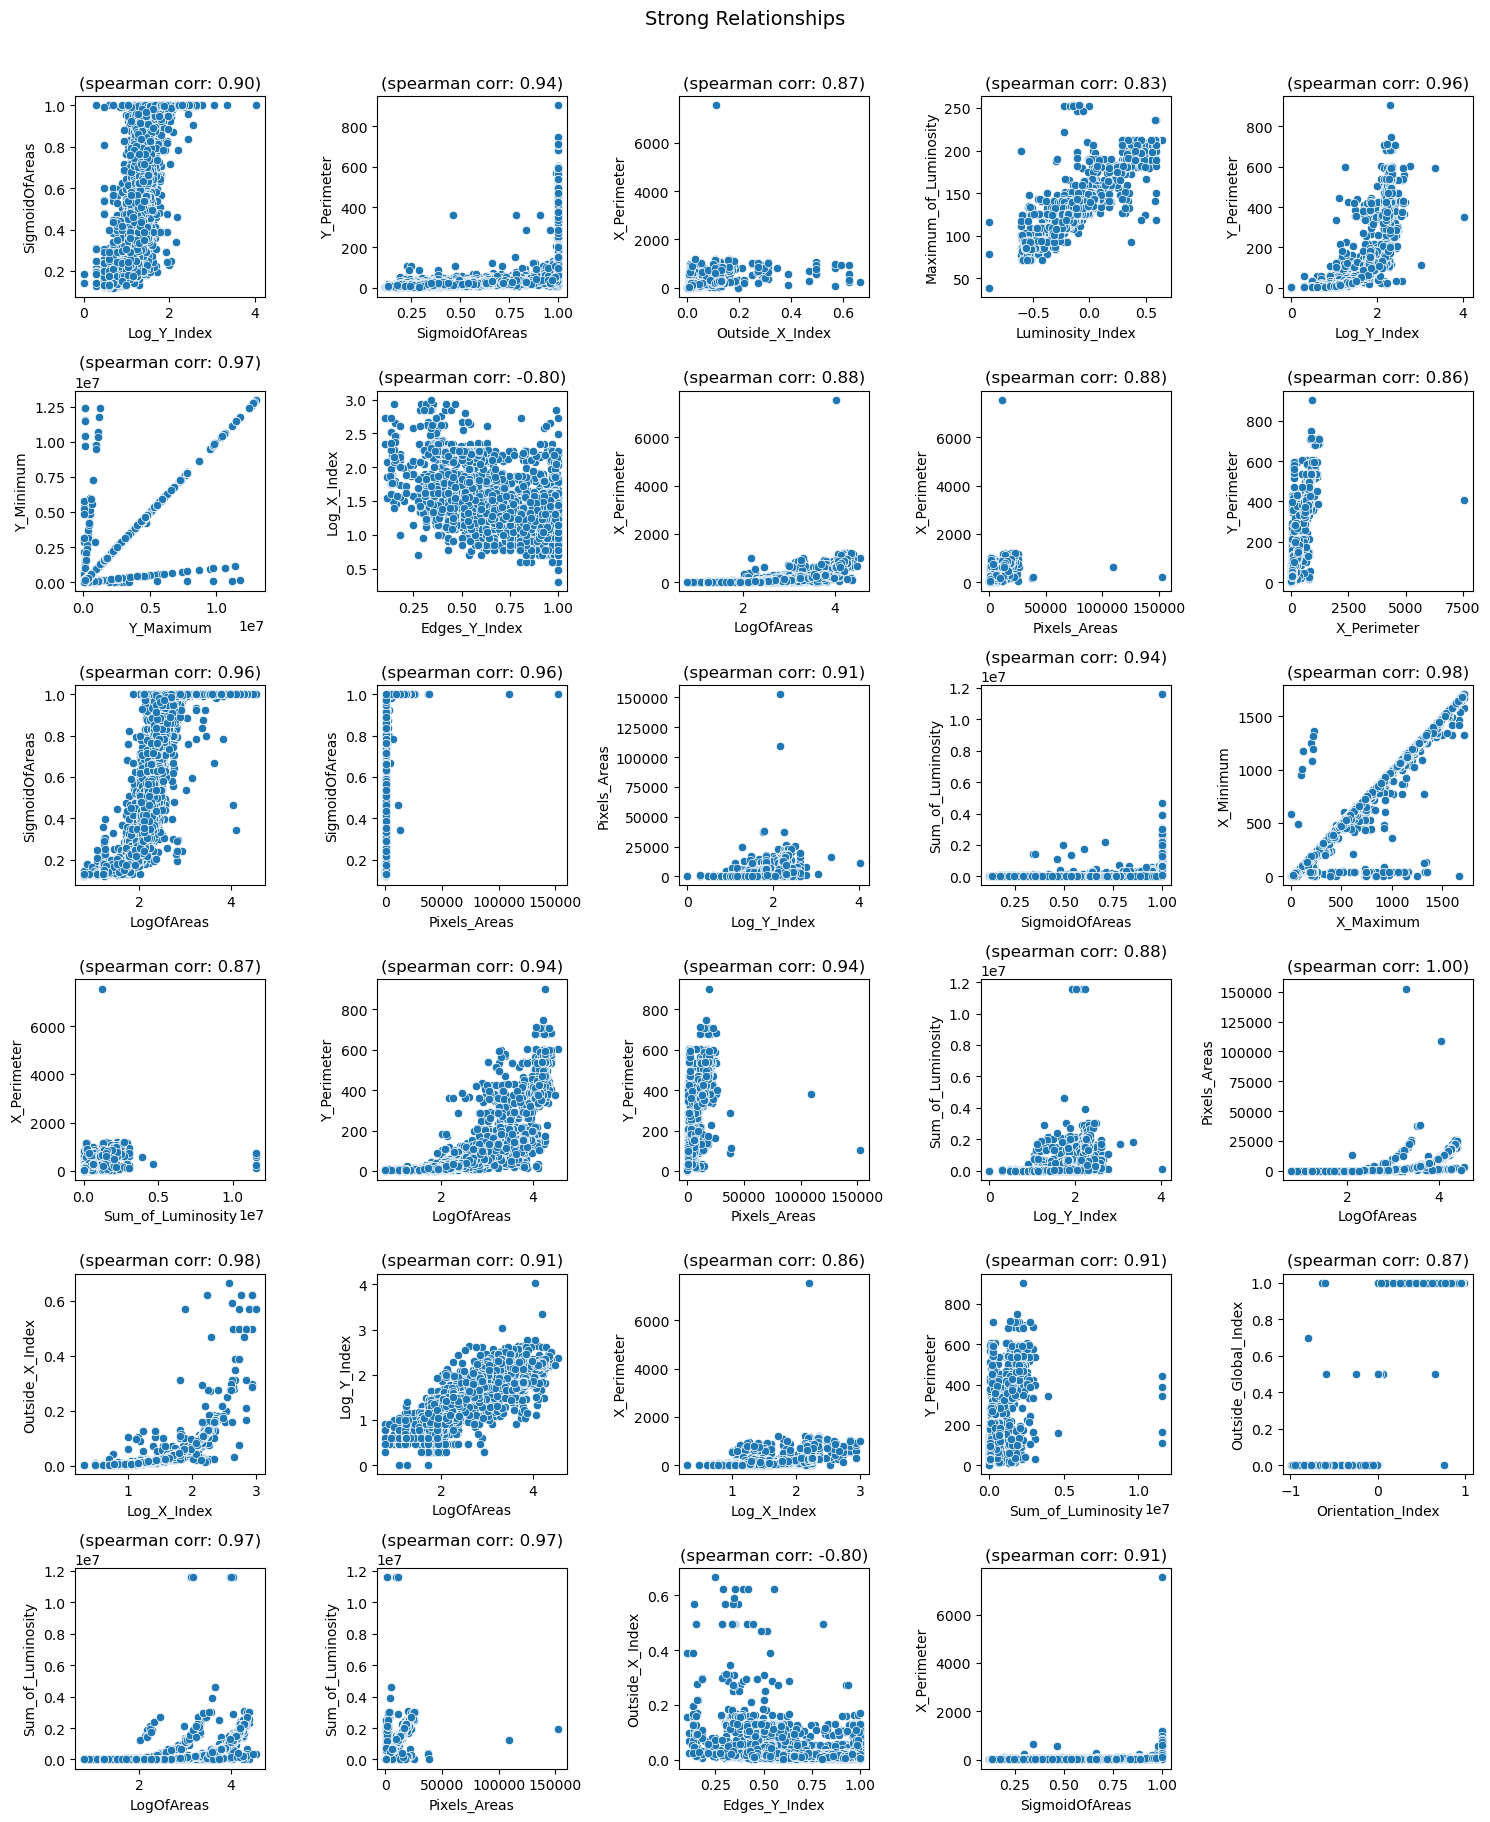

In [10]:
# Identify pairs with strong monotonic relationships (above 0.8 or below -0.8)

corr_thr = 0.8
corr_method = 'spearman'
corr = train[num_features].corr(corr_method)

strong_pairs = [
    (col1, col2) for col1 in corr.columns for col2 in corr.columns
    if col1 != col2 and abs(corr.loc[col1, col2]) > corr_thr
]

strong_pairs = list(set(tuple(sorted(pair)) for pair in strong_pairs))




ncols = 5
nrows = ceil(len(strong_pairs)/ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
axes = axes.flatten()  

for i, (col1, col2) in enumerate(strong_pairs):
    ax = axes[i] 
    sns.scatterplot(data=train, x=col1, y=col2, ax=ax)
    ax.set_title(f"({corr_method} corr: {corr.loc[col1, col2]:.2f})")
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Strong Relationships', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()


#### 2.2.1. Heatmap

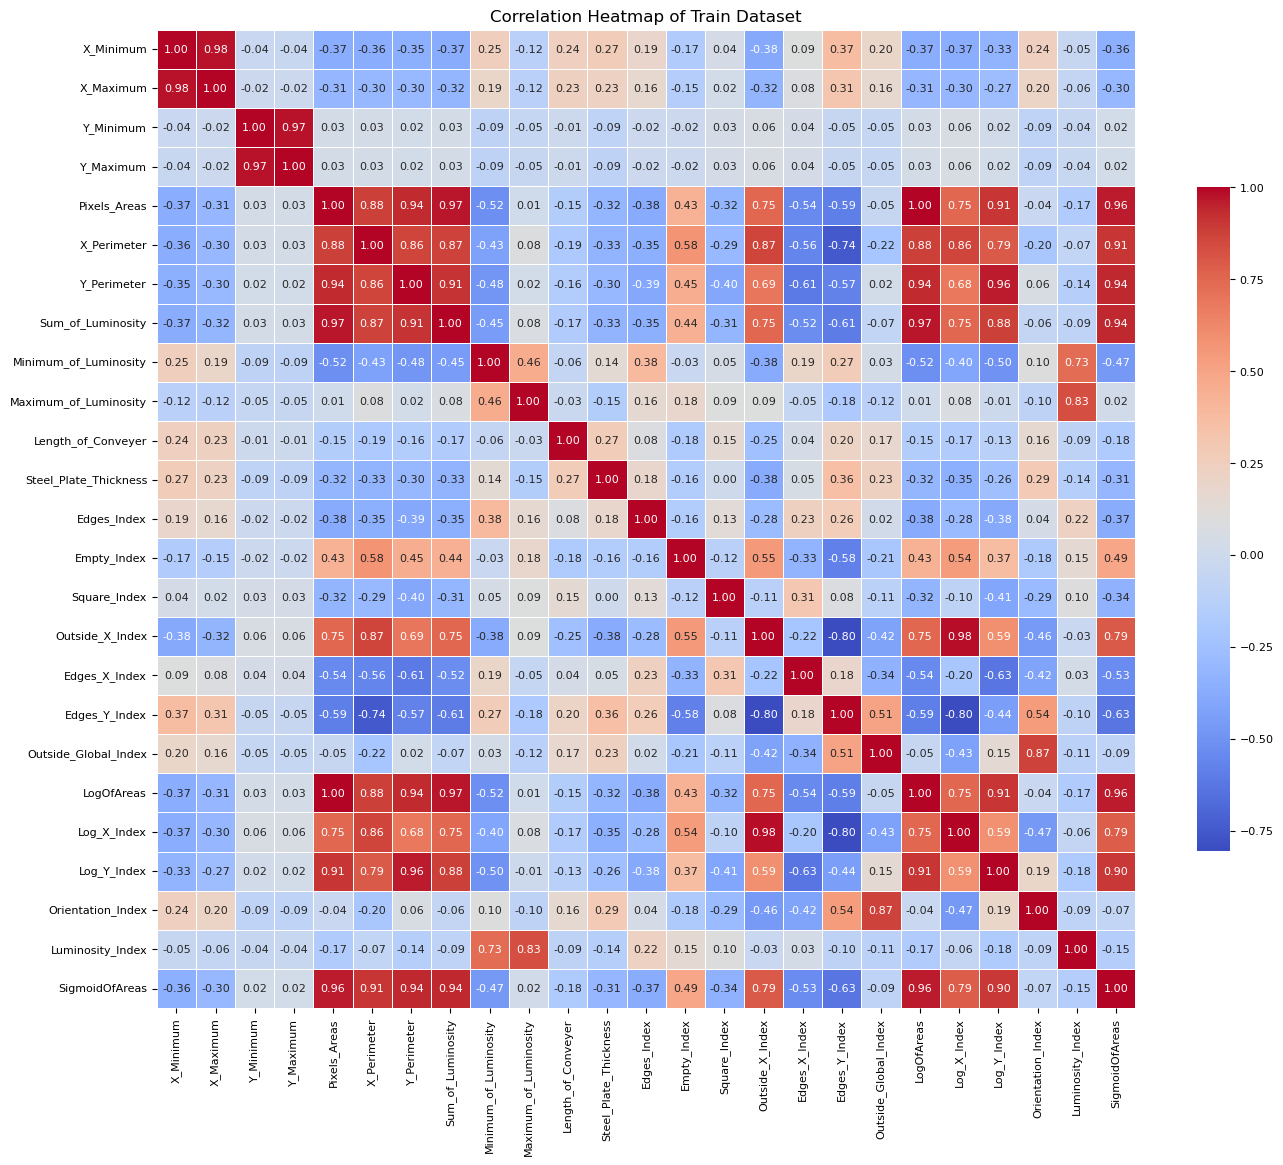

In [11]:
plt.figure(figsize=(14, 14))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title('Correlation Heatmap of Train Dataset')
plt.tight_layout()
plt.show()

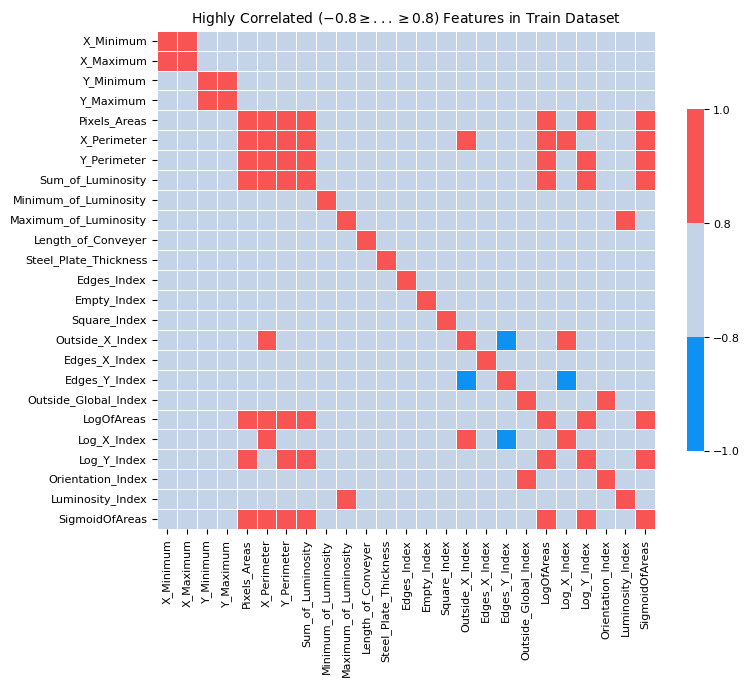

In [12]:
import matplotlib.colors as mcolors


plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#C5D3E8', '#F95454'])
bounds = [-1, -corr_thr, corr_thr, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(fr'Highly Correlated (${-corr_thr}\geq ... \geq {corr_thr}$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

In [13]:
strong_corr_pairs = []
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) >= corr_thr:
            strong_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j].round(3)))

high_corr_df = pd.DataFrame(strong_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df

,Feature 1,Feature 2,Correlation
0,X_Minimum,X_Maximum,0.978
1,Y_Minimum,Y_Maximum,0.974
2,Pixels_Areas,X_Perimeter,0.878
3,Pixels_Areas,Y_Perimeter,0.935
4,Pixels_Areas,Sum_of_Luminosity,0.967
5,Pixels_Areas,LogOfAreas,0.998
6,Pixels_Areas,Log_Y_Index,0.905
7,Pixels_Areas,SigmoidOfAreas,0.961
8,X_Perimeter,Y_Perimeter,0.865
9,X_Perimeter,Sum_of_Luminosity,0.871


#### 2.2.2. Hierarchial Clustering

The strongly correlated pairs are listed above. However, this does not specify clusters of highly-correlated features, such as `Pixels_Areas`, `X_Perimeter`, and `Y_Perimeter`. 

To get these clusters, one approach is to convert the correlation matrix to a distance matrix (aka. dissimilarity matrix) suitable for clustering. High correlation (close to 1 or -1) results in small distances, so highly correlated features will be closer in the clustering.

$$d(x_i, x_j) = 1 - r_s(x_i, x_j)$$

Then, apply hierarchical clustering on the correlation matrix to identify clusters of highly correlated features. Betweeh the two methods namely "complete" and "ward", the latter is used since it is less influence by the outliers. Here is the comparison between the two methods:

The `ward` and `complete` methods are two different linkage criteria used in hierarchical clustering when computing the distance between clusters. These methods determine how the distance between clusters is measured and affect the formation of the clusters in hierarchical clustering algorithms. Here's a breakdown of the differences between the two:

| **Aspect**| **Ward's Method**| **Complete Linkage**|
|-----------|------------------|---------------------|
| **Objective**| Minimizes the within-cluster variance.| Maximizes the distance between clusters.|
| **Cluster Shape**| Produces compact, spherical clusters.| Produces elongated or irregular clusters.|
| **Sensitivity to Outliers**| Less sensitive to outliers.| More sensitive to outliers.|
| **Distance Metric**| Distance is based on centroids.| Distance is based on the maximum pairwise distance between points.|
| **Use Cases**| Suitable when you want compact clusters.| Suitable for identifying long-distance, spread-out clusters.|

* __Ward__
    Ward's method minimizes the total within-cluster variance. When two clusters are merged, the increase in the total variance of the merged cluster is minimized. This results in compact, spherical clusters.

    Ward's method calculates the squared Euclidean distance between the centroids (mean) of the clusters and merges the pair of clusters whose merging results in the smallest increase in the squared error. Essentially, it tries to minimize the increase in the sum of squared distances within all clusters.

    The distance between two clusters is the increase in the sum of squared distances to the mean of the merged cluster.

    $$D(C_1, C_2) = \sqrt{\frac{N_1 N_2}{N_1 + N_2} \|\bar{x_1} - \bar{x_2} \|^2}$$

    where 
    * $C_1$ and $C_2$ are the two clusters being merged,
    * $N_1$ and $N_2$ are the number of points in each cluster,
    * $\bar{x_1}$ and $\bar{x_2}$ are the centroids of the clusters.

* __Complete__
    The complete method, also known as the maximal linkage or furthest point linkage, calculates the distance between two clusters by looking at the maximum distance between any two points, one from each cluster.

    When two clusters are merged, the distance is defined as the maximum distance between any two points (one from each cluster). The furthest distance between points is used to determine how far apart the clusters are.

    The distance between two clusters is the maximum distance between any pair of points from the two clusters.

    $$D(C_1, C_2)=\max{\|x_1 - x_2\|: x_1 \in C_1, x_2 \in C_2}$$

    where:
    * $x_1$ amd $x_2$ are the points from clusters $C_1$ and $C_2$, respectively.

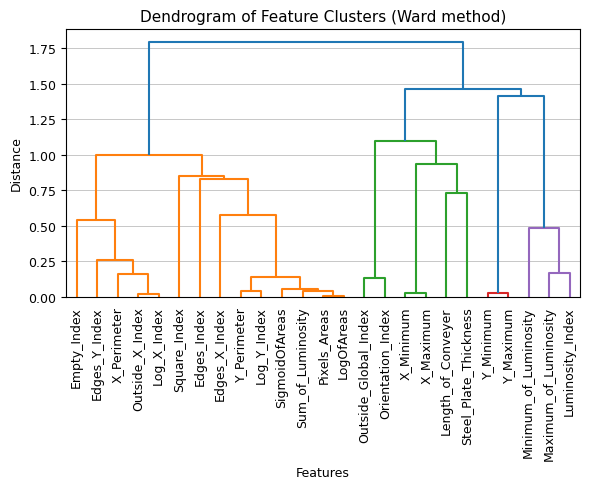

In [14]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd


# Convert the correlation matrix to a distance matrix (1 - correlation)
distance_matrix = 1 - corr.abs()

# Ensure the matrix is symmetric
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Set diagonal elements to zero (no self-distance)
np.fill_diagonal(distance_matrix.values, 0)

# Convert the symmetric distance matrix to a condensed format
condensed_distance = ssd.squareform(distance_matrix)

# Perform hierarchical clustering using the condensed distance matrix
linkage_method = 'ward'
linked = sch.linkage(condensed_distance, method=linkage_method, metric='correlation')



# Plot a dendrogram to visualize the clusters
plt.figure(figsize=(6, 5))
dendrogram = sch.dendrogram(linked, labels=corr.columns, leaf_rotation=90, leaf_font_size=9)
plt.title('Dendrogram of Feature Clusters (Ward method)', fontsize=11)
plt.xlabel('Features', fontsize=9)
plt.ylabel('Distance', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


In [15]:
from scipy.cluster.hierarchy import fcluster

# Set a threshold distance for clusters (e.g., 0.20)
dist_thr = 0.20
clusters = fcluster(linked, dist_thr, criterion='distance')

# Create a dictionary to group features by clusters
cluster_dict = {}
for i, cluster_id in enumerate(clusters):
    feature = corr.columns[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(feature)

# Display clusters of highly correlated features
print(f'Number of clusters: {len(cluster_dict)}\n')
for cluster_id, features in cluster_dict.items():
    print(f"Cluster {cluster_id}: {features}")


Number of clusters: 14

Cluster 9: ['X_Minimum', 'X_Maximum']
Cluster 12: ['Y_Minimum', 'Y_Maximum']
Cluster 4: ['Pixels_Areas', 'Y_Perimeter', 'Sum_of_Luminosity', 'LogOfAreas', 'Log_Y_Index', 'SigmoidOfAreas']
Cluster 1: ['X_Perimeter', 'Outside_X_Index', 'Log_X_Index']
Cluster 14: ['Minimum_of_Luminosity']
Cluster 13: ['Maximum_of_Luminosity', 'Luminosity_Index']
Cluster 10: ['Length_of_Conveyer']
Cluster 11: ['Steel_Plate_Thickness']
Cluster 6: ['Edges_Index']
Cluster 3: ['Empty_Index']
Cluster 7: ['Square_Index']
Cluster 5: ['Edges_X_Index']
Cluster 2: ['Edges_Y_Index']
Cluster 8: ['Outside_Global_Index', 'Orientation_Index']


In [16]:
# Select one feature from each cluster to keep
selected_num_features = [features[0] for features in cluster_dict.values()]
print(f'Number of selected numerical features: {len(selected_num_features)}')

Number of selected numerical features: 14


## Pre-Processing


### 1. Create Pipelines

In [17]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

cat_pipeline = 'passthrough'
num_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, ['TypeOfSteel_A300']),
    ('num', num_pipeline, selected_num_features)
])

### 2. Split Train Data

In [20]:
from sklearn.model_selection import train_test_split

features = selected_num_features + ['TypeOfSteel_A300']
X_train, X_val, y_train, y_val = train_test_split(train[features], target, test_size=0.2, random_state=7)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (15375, 15)
X_val shape: (3844, 15)
y_train shape: (15375, 7)
y_val shape: (3844, 7)


In [21]:
print(f'Number of missing values in X_train: {X_train.isna().sum().sum()}')
print(f'Number of missing values in X_val: {X_val.isna().sum().sum()}')
print(f'Number of missing values in y_train: {y_train.isna().sum().sum()}')
print(f'Number of missing values in y_val: {y_val.isna().sum().sum()}')
print()
print(f'Number of infinite values in X_train: {np.isinf(X_train).sum().sum()}')
print(f'Number of infinite values in X_val: {np.isinf(X_val).sum().sum()}')
print(f'Number of infinite values in y_train: {np.isinf(y_train).sum().sum()}')
print(f'Number of infinite values in y_val: {np.isinf(y_val).sum().sum()}')

Number of missing values in X_train: 0
Number of missing values in X_val: 0
Number of missing values in y_train: 0
Number of missing values in y_val: 0

Number of infinite values in X_train: 0
Number of infinite values in X_val: 0
Number of infinite values in y_train: 0
Number of infinite values in y_val: 0


## Multi-Output Classification

Since there are 7 targets, this is a multi-output classification problem, where each sample has multiple labels whose probabilities need to be predicted.

### 1. Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ('prep', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_jobs=n_jobs))
])

rf_clf.fit(X_train, y_train['Pastry'])

In [ ]:
importance_df = pd.DataFrame({
    'features': train.columns, 
    'importances': rf_clf['clf'].feature_importances_
}).sort_values('importances', ascending=False)

plt.figure(figsize=(3, 6))
sns.barplot(data=importance_df, x='importances', y='features', palette='flare', hue='importances', legend=False)
plt.ylabel('Features')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

features = importance_df[importance_df['importances']>0.03]['features'].tolist()
label = 'Pastry'

param_dist = {
    'clf__n_estimators': randint(1, 1000),
    'clf__max_depth': randint(1, 1000)
}

rf_clf = Pipeline(steps=[
   ('prep', StandardScaler()), 
   ('clf', RandomForestClassifier(n_jobs=n_jobs))
])

rnd_srch = RandomizedSearchCV(
    rf_clf,
    param_distributions = param_dist,
    n_iter = 500,
    cv=3,
    scoring = 'roc_auc',
    return_train_score=True,
    n_jobs=n_jobs,
    error_score='raise',  # Raise errors to see issues
    verbose=1
)

rnd_srch.fit(X_train[features], y_train[label])

In [ ]:
rnd_srch.best_params_

In [ ]:
rnd_srch.best_score_

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# best_params = {'clf__max_depth': 4, 'clf__n_estimators': 180} # >0.05
# best_params = {'clf__max_depth': 8, 'clf__n_estimators': 637} # >0.04
best_params = {'clf__max_depth': 8, 'clf__n_estimators': 926} # >0.03
rf_clf.set_params(**best_params)

rf_clf.fit(X_train[features], y_train[label])

y_score = rf_clf.predict_proba(X_val[features])
fpr, tpr, _ = roc_curve(y_val[label], y_score[:, 1])
auc = roc_auc_score(y_val[label], y_score[:, 1])  

print(auc)

### 2. XGBoost Classifier

In [20]:
from xgboost import XGBClassifier

param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'device': 'gpu',
    'seed': 7
}

imp_df = pd.DataFrame(index=train.columns)
for col in target.columns:
    xgb_clf = XGBClassifier(**param)
    xgb_clf.fit(X_train, y_train[col])
    imp_df[col] = xgb_clf.feature_importances_

Number of features selected for each target  with importance > 0.01:

Pastry: 27
Z_Scratch: 26
K_Scatch: 10
Stains: 7
Dirtiness: 26
Bumps: 27
Other_Faults: 27


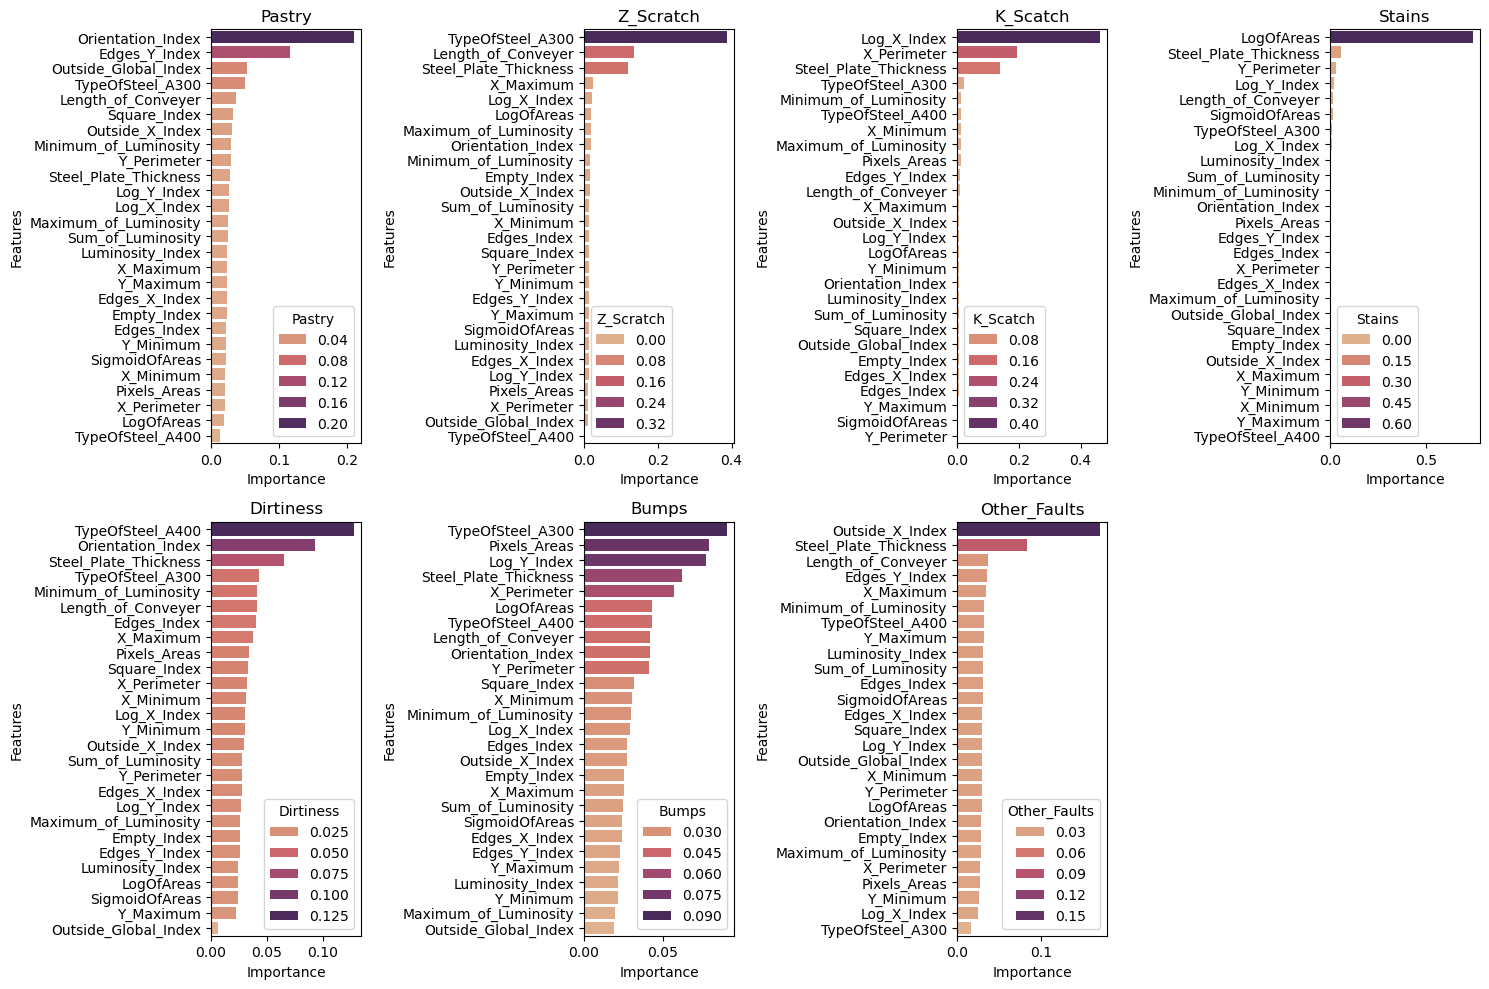

In [22]:
imp_thr = 0.01
print(f"Number of features selected for each target  with importance > {imp_thr}:\n")
for col in target.columns:
    # print(f'{col}:{imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist()}')
    print(f'{col}: {len(imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist())}')



ncols = 4
nrows = ceil(len(target.columns)/ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
ax = ax.ravel()

for i, col in enumerate(target.columns):
    data = imp_df[col].sort_values(ascending=False)
    sns.barplot(x=data, y=data.index, palette='flare', hue=data, ax=ax[i])
    ax[i].set_title(f'{col}')
    ax[i].set_ylabel('Features')
    ax[i].set_xlabel('Importance')
    
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])
    
plt.tight_layout()
plt.show()

#### Bayesian Optimization

__Note:__

`xgb.DMatrix` is a special data structure provided by XGBoost that is optimized for training and evaluation. It is designed to handle large datasets efficiently and is required for most XGBoost training APIs.

In [ ]:
# Independent Hyperparameter Tuning

import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Define the parameter space
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),  # learning_rate
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),  # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),  # L1 regularization
        'seed': 42
    }

    # Initialize XGBoost DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Perform cross-validation
    cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        metrics='auc',
        seed=42,
        verbose_eval=False  # Reduces verbosity
    )

    # Return the best AUC score
    return cv_results['test-auc-mean'].max()

# Create a study and optimize it
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Print the best parameters and score
print("Best Parameters:", study.best_params)
print("Best AUC Score:", study.best_value)


In [ ]:
# Find the best parameters for each label independently (one set of parameters per label)

import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# Function to perform hyperparameter tuning for each label
def tune_model_for_each_label(X_train, y_train, imp_df=None, imp_thr=0.0, filename='best_params.json'):
    best_params = {}
    best_scores = {}

    for label in y_train.columns:
        print(f"Tuning for label '{label}'...")

        # Define the objective function for Optuna
        def objective(trial):

            param = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'booster': 'gbtree',
                'device': 'gpu',
                'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
                'eta': trial.suggest_float('eta', 1e-3, 0.1, log=True),  # learning_rate
                'max_depth': trial.suggest_int('max_depth', 2, 10),
                'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
                'gamma': trial.suggest_float('gamma', 0, 1.0),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
                'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
                'random_state': 7
            }

            model = Pipeline(steps=[
                ('prep', StandardScaler()),
                ('clf', xgb.XGBClassifier(**param))
            ])
            
            auc_scorer = make_scorer(roc_auc_score)
            
            # Select feature based on importance threshold
            if imp_df is not None:
                features = imp_df[imp_df[label]>imp_thr][label].sort_values(ascending=False).index.tolist()
            else:
                features = X_train.columns.tolist()

            
            scores = cross_val_score(model, X_train[features], y_train[label], cv=5, scoring=auc_scorer)

            return scores.mean()

        # Create a study and optimize it
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=7))
        study.optimize(objective, n_trials=100)

        best_params[label] = study.best_params
        best_scores[label] = study.best_value

        print(f"Best Parameters for {label}: {study.best_params}")
        print(f"Best AUC Score for {label}: {study.best_value}\n")
    
    save_params(best_params, filename)
    
    return best_params, best_scores


best_params, best_scores = tune_model_for_each_label(X_train, y_train, filename='xgb_best_params_labels.json')


Tuning for label 'Pastry'...
Best Parameters for Pastry: {'n_estimators': 217, 'eta': 0.49818150166792435, 'max_depth': 7, 'min_child_weight': 6.361029141118849, 'gamma': 0.3826755348957721, 'subsample': 0.5004825193162402, 'colsample_bytree': 0.7166180633472058, 'lambda': 0.22593878696227776, 'alpha': 0.25301042382632966}
Best AUC Score for Pastry: 0.6034052224769216
Tuning for label 'Z_Scratch'...
Best Parameters for Z_Scratch: {'n_estimators': 609, 'eta': 0.03575435652412183, 'max_depth': 2, 'min_child_weight': 0.004610176840628468, 'gamma': 0.945504456072845, 'subsample': 0.9382389871805222, 'colsample_bytree': 0.9457514178695665, 'lambda': 0.09558612114032082, 'alpha': 0.021643329885993056}
Best AUC Score for Z_Scratch: 0.7558282867493122
Tuning for label 'K_Scatch'...
Best Parameters for K_Scatch: {'n_estimators': 504, 'eta': 0.02237362664528599, 'max_depth': 10, 'min_child_weight': 3.6687840168195187, 'gamma': 0.7545160469286188, 'subsample': 0.8558906000948321, 'colsample_bytre

In [ ]:
# Compute the mean AUC score for the validation set using the best parameters

import xgboost as xgb
from sklearn.metrics import roc_auc_score



def create_and_predict(model, X_train, y_train, X_val, y_val, imp_df, imp_thr=0.0, filename='best_params.json'):
    
    best_params = load_params(filename)
    
    auc_scores = []
    features = imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist()
    
    for label, params in best_params.items():
        
        print(f"Training model for label: '{label}'...")
        model.set_params(**params)
        model.fit(X_train[features], y_train[label])
        
        y_pred_probs = model.predict_proba(X_val[features])[:, 1] # positive class probabilities
        auc = roc_auc_score(y_val[label], y_pred_probs)
        auc_scores.append(auc)
        print(f"AUC for label '{label}': {auc:.4f}")

    mean_auc = sum(auc_scores) / len(auc_scores)
    print(f"Mean AUC: {mean_auc:.4f}")
    return mean_auc





Training model for label: 'Pastry'...
AUC for label 'Pastry': 0.7917
Training model for label: 'Z_Scratch'...
AUC for label 'Z_Scratch': 0.9651
Training model for label: 'K_Scatch'...
AUC for label 'K_Scatch': 0.9869
Training model for label: 'Stains'...
AUC for label 'Stains': 0.9922
Training model for label: 'Dirtiness'...
AUC for label 'Dirtiness': 0.8441
Training model for label: 'Bumps'...
AUC for label 'Bumps': 0.8113
Training model for label: 'Other_Faults'...
AUC for label 'Other_Faults': 0.7062
Mean AUC: 0.8711


In [ ]:
# Evaluate the model using the best parameters

model = xgb.XGBClassifier()
best_params_file = 'xgb_best_params_labels.json'
mean_auc = create_and_predict(model, X_train, y_train, X_val, y_val, imp_df, imp_thr=0.0, filename=best_params_file)


In [ ]:
# Find the best hyperparameters for the entire multilabel classification problem (one set of parameters for all labels)

import json
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier


optuna.logging.set_verbosity(optuna.logging.INFO)

def tune_model_for_each_label(X_train, y_train, imp_df, imp_thr=0.0, filename='best_params.json'):
    
    # Define the objective function for Optuna
    def objective(trial):

        param = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': 'gbtree',
            'device': 'gpu',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'eta': trial.suggest_float('eta', 0.01, 0.5, log=True),  # learning_rate
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 0, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
            'random_state': 7
        }

        model = xgb.XGBClassifier(**param)
        multi_target_model = MultiOutputClassifier(model, n_jobs=-1)

        auc_scorer = make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
        features = imp_df[imp_df[col]>imp_thr][col].sort_values(ascending=False).index.tolist()
        scores = cross_val_score(multi_target_model, X_train[features], y_train, cv=5, scoring=auc_scorer)

        return scores.mean()

    # Create a study and optimize it using Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=7))
    study.optimize(objective, n_trials=50)

    print("Best Parameters: ", study.best_params)
    print("Best AUC Score: ", study.best_value)
    
    save_params(study.best_params, filename)

    return study.best_params, study.best_value



best_params, best_score = tune_model_for_each_label(X_train, y_train, imp_df, imp_thr=0.05, filename='xgb_best_params_all.json')


[I 2024-11-06 13:26:32,008] A new study created in memory with name: no-name-6f452d13-9861-4bfa-84a3-0a710935cb74
[I 2024-11-06 13:27:20,636] Trial 0 finished with value: 0.6408117322316705 and parameters: {'n_estimators': 168, 'eta': 0.2113774399969529, 'max_depth': 5, 'min_child_weight': 0.7831784183433459, 'gamma': 0.9779895119966027, 'subsample': 0.7692479352052168, 'colsample_bytree': 0.7505602318299689, 'lambda': 0.001644952645417171, 'alpha': 0.0063872944941386735}. Best is trial 0 with value: 0.6408117322316705.
[I 2024-11-06 13:28:19,110] Trial 1 finished with value: 0.6419932338772987 and parameters: {'n_estimators': 550, 'eta': 0.14255793290546973, 'max_depth': 9, 'min_child_weight': 0.03340138940215421, 'gamma': 0.06593634690590511, 'subsample': 0.6440727996539968, 'colsample_bytree': 0.9547967638598068, 'lambda': 0.004366727193933745, 'alpha': 0.02271809364813245}. Best is trial 1 with value: 0.6419932338772987.
[W 2024-11-06 13:28:27,456] Trial 2 failed with parameters: {

KeyboardInterrupt: 

In [ ]:
# Evaluate the model using the best parameters

model = MultiOutputClassifier(xgb.XGBClassifier())
best_params_file = 'xgb_best_params_all.json'
mean_auc = create_and_predict(model, X_train, y_train, X_val, y_val, imp_df, imp_thr=0.0, filename=best_params_file)

### 3. LightGBM

In [210]:
import lightgbm as lgb

In [279]:
label = 'Pastry'

train_data = lgb.Dataset(X_train, label=y_train[label])
test_data = lgb.Dataset(X_val, label=y_val[label], reference=train_data)

In [280]:
params = {
    'objective': 'binary',  # Use 'multiclass' for multi-class classification
    'metric': 'auc',  # Use 'multi_error' for multi-class classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9  # Fraction of features to use per iteration
}


In [ ]:
# Train the LightGBM model
num_round = 100
model = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[test_data],  # Validation data to monitor performance
)


In [282]:
# Predict probabilities
y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)

# Convert probabilities to class labels (for binary classification)
y_pred = np.round(y_pred_proba)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Calculate accuracy
accuracy = accuracy_score(y_val[label], y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate ROC AUC score (if applicable)
roc_auc = roc_auc_score(y_val[label], y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'num_leaves': randint(1, 500), # [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': randint(1,10), # [-1, 5, 10],
    'feature_fraction': uniform(loc=0, scale=1.0), # [0.8, 0.9, 1.0],
    'bagging_fraction': uniform(loc=0, scale=1.0), # [0.8, 0.9, 1.0],
    'pos_bagging_fraction': uniform(loc=0, scale=1.0),
    'neg_bagging_fraction': uniform(loc=0, scale=1.0),
    'bagging_freq': randint(1, 10) #  [0, 5, 10]
}

lgb_model = lgb.LGBMClassifier()

random_search = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=param_dist, 
    scoring='roc_auc', 
    cv=5, 
    n_iter=100, 
    random_state=42,
    verbose=0
)

random_search.fit(X_train, y_train[label])

print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)


In [ ]:

params =  {
    'bagging_fraction': 0.51, 
    'bagging_freq': 6, 
    'feature_fraction': 0.27,
    'learning_rate': 0.05, 
    'max_depth': 6, 
    'neg_bagging_fraction': 0.98, 
    'num_leaves': 51, 
    'pos_bagging_fraction': 0.89}

lgb_model = lgb.LGBMClassifier()
lgb_model.set_params(**params)
lgb_model.fit(X_train, y_train[label])

# Predict probabilities
y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)

# Convert probabilities to class labels (for binary classification)
y_pred = np.round(y_pred_proba)


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_val[label], y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate ROC AUC score (if applicable)
roc_auc = roc_auc_score(y_val[label], y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

##### 4.1. Bayesian Optimization

Bayesian Optimization is more efficient than Grid or Randomized Search because it uses past evaluations to decide on the next set of hyperparameters to try. Libraries like `hyperopt` and `optuna` are commonly used.

In [32]:
import optuna
import lightgbm as lgb

In [ ]:
def objective(trial):
    # Define the parameter space using updated methods
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'verbose': -1
    }
    
    # Train LightGBM model
    lgb_train = lgb.Dataset(X_train, label=y_train[label])
    cv_results = lgb.cv(
        param, 
        lgb_train, 
        nfold=5, 
        stratified=True, 
        metrics='auc',  
        seed=42
    )
       
    # Return the best AUC score using the correct key
    if 'valid auc-mean' in cv_results:
        return max(cv_results['valid auc-mean'])
    else:
        available_keys = str(cv_results.keys())
        raise KeyError(f"Key 'valid auc-mean' not found in cv_results. Available keys: {available_keys}")

# Create a study and optimize it
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters and score
print("Best Parameters:", study.best_params)
print("Best AUC Score:", study.best_value)


In [291]:
params =  {
    'num_leaves': 37, 
    'learning_rate': 0.07312524871360267, 
    'max_depth': 3, 
    'feature_fraction': 0.9110066330284466, 
    'bagging_fraction': 0.8393070430983256, 
    'bagging_freq': 2
}

lgb_model = lgb.LGBMClassifier()
lgb_model.set_params(**params)
lgb_model.fit(X_train, y_train[label])

# Predict probabilities
y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)

# Convert probabilities to class labels (for binary classification)
y_pred = np.round(y_pred_proba)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_val[label], y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate ROC AUC score (if applicable)
roc_auc = roc_auc_score(y_val[label], y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

In [ ]:
# Independent Hyperparameter Tuning

def objective(trial):

    auc_scores = []
    
    # Train LightGBM model for each label with its own hyperparameters
    for i in range(y_train.shape[1]):
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int(f'num_leaves_{i}', 15, 63),
            'learning_rate': trial.suggest_float(f'learning_rate_{i}', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int(f'max_depth_{i}', -1, 15),
            'feature_fraction': trial.suggest_float(f'feature_fraction_{i}', 0.8, 1.0),
            'bagging_fraction': trial.suggest_float(f'bagging_fraction_{i}', 0.8, 1.0),
            'bagging_freq': trial.suggest_int(f'bagging_freq_{i}', 0, 10),
            'verbose': -1
        }

        lgb_train = lgb.Dataset(X_train, label=y_train.iloc[:, i])
        
        cv_results = lgb.cv(
            param,
            lgb_train,
            nfold=5,
            stratified=True,
            metrics='auc',
            seed=42
        )
        
        auc_scores.append(max(cv_results['valid auc-mean']))

    # Return the average AUC score across all labels
    return np.mean(auc_scores)



# Create a study and optimize it
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

# Print the best parameters and score
print("Best Parameters:", study.best_params)
print("Best AUC Score:", study.best_value)


In [ ]:
study.best_params.keys()